In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import math
import numpy as np
import random
import collections
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('CartPole-v0').unwrapped
env.reset()

array([0.04323337, 0.02758824, 0.04674358, 0.04000396])

In [3]:
EPISODES = 700
LR = 0.001
GAMMA = 0.999
eps = 0.99
EPS_MIN = 0.01
EPS_DECAY = 0.99
HIDDEN_LAYER1 = 32
HIDDEN_LAYER2 = 16
BATCH_SIZE = 256
NUM_ACTIONS = env.action_space.n
NUM_OBS = len(env.reset())
CAPACITY = 10000
STEPS = 0
TARGET_UPDATE = 10
EPISODE_DURATION = []
REWARDS = []
AVG_OVER_100 = []
MAX_LOSS = []
STACKED_STATES = 4
FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor

In [4]:
class Replaymemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.index = 0
        
    def push(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.index] = transition
        self.index = (self.index + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
        
    def __len__(self):
        return len(self.memory)

In [5]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc0 = nn.Linear(NUM_OBS * STACKED_STATES, HIDDEN_LAYER1)
        self.fc1 = nn.Linear(HIDDEN_LAYER1, HIDDEN_LAYER2)
        self.fc2 = nn.Linear(HIDDEN_LAYER2, NUM_ACTIONS)
    
    def forward(self, x):
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
policy_net = Network()
target_net = Network()
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr = LR)
memory = Replaymemory(CAPACITY)

In [7]:
def epsilon_greedy(state):
    prob = random.random()
    if prob < eps:
        action = torch.tensor(random.randrange(NUM_ACTIONS))
    else:
        with torch.no_grad():
            action = policy_net(state).argmax()
    return action.item()

In [8]:
def optimize():
    if len(memory) < BATCH_SIZE:
        print('not enough memory samples')
        return
    trans = memory.sample(BATCH_SIZE)
    state_batch, action_batch, next_state_batch, reward_batch = zip(*trans)

    is_non_terminating = torch.tensor(tuple(map(lambda q: q is not None, next_state_batch)), dtype = torch.bool)
    
    non_final_next_states = torch.tensor([i for i in next_state_batch if i is not None], dtype = torch.float)
    
    state_batch = torch.tensor(state_batch, dtype = torch.float)
    action_batch = torch.tensor(action_batch, dtype = torch.long)
    reward_batch = torch.tensor(reward_batch, dtype = torch.float)
    
    curr_q_vals = policy_net(state_batch.reshape(BATCH_SIZE, STACKED_STATES * NUM_OBS).squeeze(0)).gather(1, action_batch.view(-1, 1))
    
    max_q_vals = torch.zeros(BATCH_SIZE)
    
    max_q_vals[is_non_terminating] = target_net(non_final_next_states.reshape(is_non_terminating.sum().item(), STACKED_STATES * NUM_OBS).squeeze(0)).max(1)[0].detach()
    
    next_q_vals = (reward_batch + GAMMA * max_q_vals).reshape(curr_q_vals.shape)
    
    loss = F.smooth_l1_loss(curr_q_vals, next_q_vals)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()    

In [9]:
net_reward = 0
avg_100 = 0
max_reward = 0
MAX_REWARD = []

for episode in range(EPISODES):
    time_in_episode = 0
    max_loss = 0
    curr_states = []
    for i in range(STACKED_STATES):
        state = env.reset().tolist()
        curr_states.append(state)
            
    while True:
        env.render()
        time_in_episode += 1
        
        #curr_states = torch.tensor(stacked_states).reshape(1, STACKED_STATES * NUM_OBS).squeeze(0)
                
        curr_action = epsilon_greedy(torch.tensor(curr_states).reshape(1, STACKED_STATES * NUM_OBS).squeeze(0))
        obs, reward, done, info = env.step(curr_action)
        
        if eps > EPS_MIN:
            eps *= EPS_DECAY
        else:
            eps = 0.0
        
        if done:
            next_states = None
        else:
            next_states = []    
            next_states = curr_states[1:]
            next_states.append(obs.tolist())   
        
        #next_states = torch.tensor(next_states)
        
        memory.push((curr_states, curr_action, next_states, reward))
        
        loss = optimize()
        
        if loss is not None and loss > max_loss:
            max_loss = loss
            
        if reward > max_reward:
            max_reward = reward
            
        net_reward += reward
        avg_100 += reward
        
        curr_states = next_states
        
        if done:
            EPISODE_DURATION.append(time_in_episode)
            MAX_LOSS.append(max_loss)
            print(f'Maximum loss in episode {episode}: {max_loss}')
            print(f'Episode length: {time_in_episode}')
            print('\n')
            break
    
    if not episode % TARGET_UPDATE:
        target_net.load_state_dict(policy_net.state_dict())
        mean_reward = net_reward/TARGET_UPDATE
        print(f'Mean reward for last 10 episodes: {mean_reward}')
        REWARDS.append(mean_reward)
        net_reward = 0
    if not episode % 100:
        avg_over_100 = avg_100/100
        AVG_OVER_100.append(avg_over_100)
        MAX_REWARD.append(max_reward)
        print(f'Mean reward for last 100 episodes: {avg_over_100}')
        avg_100 = 0
        max_reward = 0
print('COMPLETE')
env.render()
env.close()

not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
Maximum loss in episode 0: 0
Episode length: 14


Mean reward for last 10 episodes: 1.4
Mean reward for last 100 episodes: 0.14
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
Maximum loss in episode 1: 0
Episode length: 16


not enough memory samples
not enough memor

Maximum loss in episode 27: 0.12603843212127686
Episode length: 9


Maximum loss in episode 28: 0.10479927062988281
Episode length: 8


Maximum loss in episode 29: 0.08448056876659393
Episode length: 10


Maximum loss in episode 30: 0.06143466383218765
Episode length: 13


Mean reward for last 10 episodes: 9.8
Maximum loss in episode 31: 0.5509320497512817
Episode length: 10


Maximum loss in episode 32: 0.2737310230731964
Episode length: 9


Maximum loss in episode 33: 0.23375271260738373
Episode length: 9


Maximum loss in episode 34: 0.1765095293521881
Episode length: 10


Maximum loss in episode 35: 0.12629806995391846
Episode length: 17


Maximum loss in episode 36: 0.08260663598775864
Episode length: 21


Maximum loss in episode 37: 0.07053980976343155
Episode length: 17


Maximum loss in episode 38: 0.07578222453594208
Episode length: 20


Maximum loss in episode 39: 0.06629645079374313
Episode length: 14


Maximum loss in episode 40: 0.06304945051670074
Episode length: 16


Mea

Maximum loss in episode 141: 1.060927152633667
Episode length: 11


Maximum loss in episode 142: 1.0821492671966553
Episode length: 10


Maximum loss in episode 143: 0.9149051308631897
Episode length: 10


Maximum loss in episode 144: 0.9659102559089661
Episode length: 10


Maximum loss in episode 145: 0.9802603721618652
Episode length: 10


Maximum loss in episode 146: 0.7759119868278503
Episode length: 10


Maximum loss in episode 147: 0.8925116658210754
Episode length: 9


Maximum loss in episode 148: 0.8891493082046509
Episode length: 10


Maximum loss in episode 149: 0.8197430968284607
Episode length: 10


Maximum loss in episode 150: 0.7195680141448975
Episode length: 8


Mean reward for last 10 episodes: 9.8
Maximum loss in episode 151: 1.172197937965393
Episode length: 8


Maximum loss in episode 152: 0.9435617327690125
Episode length: 10


Maximum loss in episode 153: 0.8416479825973511
Episode length: 9


Maximum loss in episode 154: 0.9834271669387817
Episode length: 10


Ma

Maximum loss in episode 254: 0.39813533425331116
Episode length: 39


Maximum loss in episode 255: 0.40678998827934265
Episode length: 39


Maximum loss in episode 256: 0.4846387803554535
Episode length: 52


Maximum loss in episode 257: 0.40371665358543396
Episode length: 48


Maximum loss in episode 258: 0.42738619446754456
Episode length: 39


Maximum loss in episode 259: 0.4714967906475067
Episode length: 54


Maximum loss in episode 260: 0.3775485157966614
Episode length: 41


Mean reward for last 10 episodes: 46.2
Maximum loss in episode 261: 0.9434323310852051
Episode length: 54


Maximum loss in episode 262: 0.6233059167861938
Episode length: 45


Maximum loss in episode 263: 0.5604641437530518
Episode length: 56


Maximum loss in episode 264: 0.5351561307907104
Episode length: 49


Maximum loss in episode 265: 0.5783388614654541
Episode length: 52


Maximum loss in episode 266: 0.5504356026649475
Episode length: 54


Maximum loss in episode 267: 0.5596426725387573
Episode leng

Maximum loss in episode 365: 0.8932633399963379
Episode length: 157


Maximum loss in episode 366: 1.212841272354126
Episode length: 297


Maximum loss in episode 367: 1.1940608024597168
Episode length: 182


Maximum loss in episode 368: 0.8277148008346558
Episode length: 128


Maximum loss in episode 369: 1.5226207971572876
Episode length: 263


Maximum loss in episode 370: 1.249794840812683
Episode length: 221


Mean reward for last 10 episodes: 254.2
Maximum loss in episode 371: 1.5927326679229736
Episode length: 238


Maximum loss in episode 372: 1.5503579378128052
Episode length: 222


Maximum loss in episode 373: 1.1907777786254883
Episode length: 133


Maximum loss in episode 374: 1.6665290594100952
Episode length: 126


Maximum loss in episode 375: 1.6741386651992798
Episode length: 377


Maximum loss in episode 376: 1.0871812105178833
Episode length: 145


Maximum loss in episode 377: 1.5122404098510742
Episode length: 131


Maximum loss in episode 378: 1.4063528776168823
Epis

Maximum loss in episode 477: 3.536991834640503
Episode length: 120


Maximum loss in episode 478: 3.1937739849090576
Episode length: 68


Maximum loss in episode 479: 2.6038663387298584
Episode length: 79


Maximum loss in episode 480: 2.707364320755005
Episode length: 90


Mean reward for last 10 episodes: 90.5
Maximum loss in episode 481: 2.873732566833496
Episode length: 75


Maximum loss in episode 482: 2.6220433712005615
Episode length: 84


Maximum loss in episode 483: 4.517667770385742
Episode length: 189


Maximum loss in episode 484: 3.929656505584717
Episode length: 81


Maximum loss in episode 485: 4.1782546043396
Episode length: 84


Maximum loss in episode 486: 2.706800699234009
Episode length: 73


Maximum loss in episode 487: 2.364769220352173
Episode length: 71


Maximum loss in episode 488: 2.9639172554016113
Episode length: 98


Maximum loss in episode 489: 3.130146026611328
Episode length: 72


Maximum loss in episode 490: 3.1720352172851562
Episode length: 69


Mean

Maximum loss in episode 590: 3.443601369857788
Episode length: 52


Mean reward for last 10 episodes: 54.7
Maximum loss in episode 591: 3.9970531463623047
Episode length: 49


Maximum loss in episode 592: 3.962270736694336
Episode length: 56


Maximum loss in episode 593: 3.900181770324707
Episode length: 53


Maximum loss in episode 594: 3.816218614578247
Episode length: 46


Maximum loss in episode 595: 4.653447151184082
Episode length: 66


Maximum loss in episode 596: 4.397407054901123
Episode length: 46


Maximum loss in episode 597: 4.859323978424072
Episode length: 55


Maximum loss in episode 598: 3.281169891357422
Episode length: 49


Maximum loss in episode 599: 4.332245826721191
Episode length: 45


Maximum loss in episode 600: 5.276713848114014
Episode length: 56


Mean reward for last 10 episodes: 52.1
Mean reward for last 100 episodes: 63.23
Maximum loss in episode 601: 4.615017414093018
Episode length: 45


Maximum loss in episode 602: 2.9495656490325928
Episode length: 

In [10]:
def plot_durations():
    plt.figure(figsize=(15,10))
    plt.xlabel('EPISODE')
    plt.ylabel('DURATION')
    plt.plot(EPISODE_DURATION)
    plt.grid()
    plt.show()

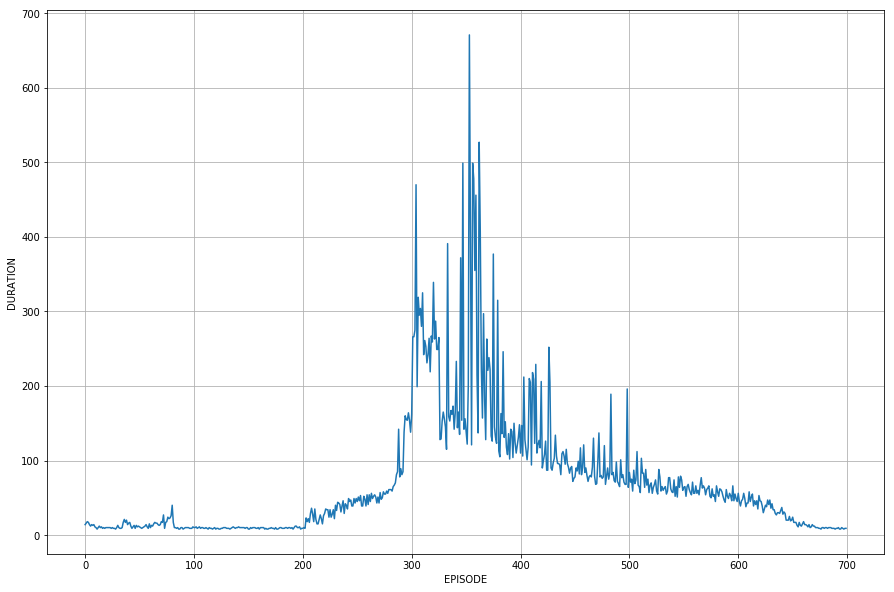

In [11]:
plot_durations()

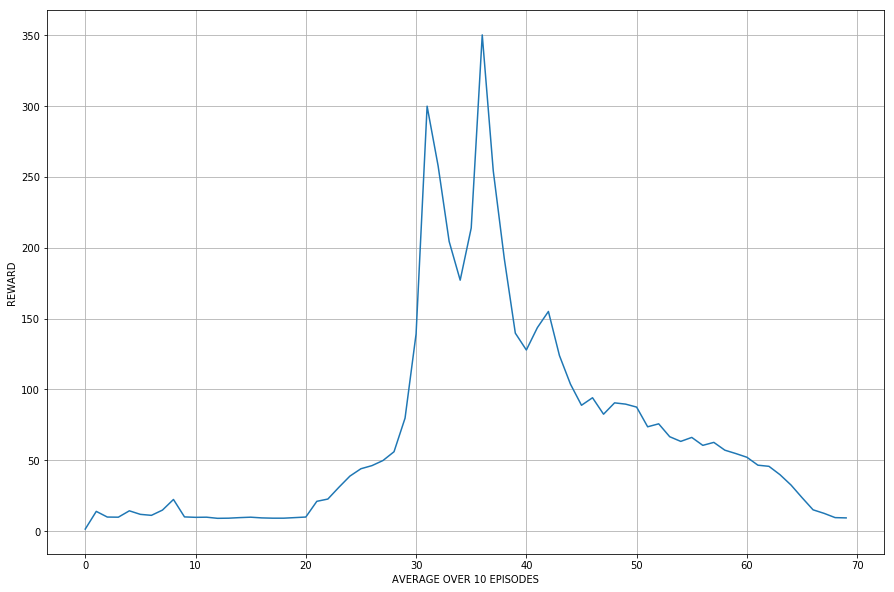

In [12]:
def plot_rewards():
    plt.figure(figsize=(15,10))
    plt.xlabel('AVERAGE OVER 10 EPISODES')
    plt.ylabel('REWARD')
    plt.plot(REWARDS)
    plt.grid()
    plt.show()
plot_rewards()

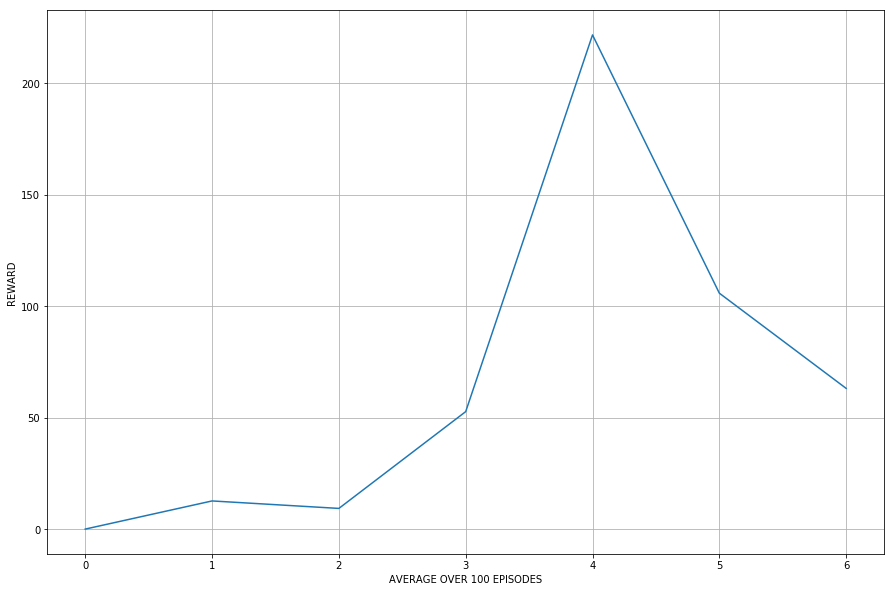

In [13]:
def plot_rewards():
    plt.figure(figsize=(15,10))
    plt.xlabel('AVERAGE OVER 100 EPISODES')
    plt.ylabel('REWARD')
    plt.plot(AVG_OVER_100)
    plt.grid()
    plt.show()
plot_rewards()

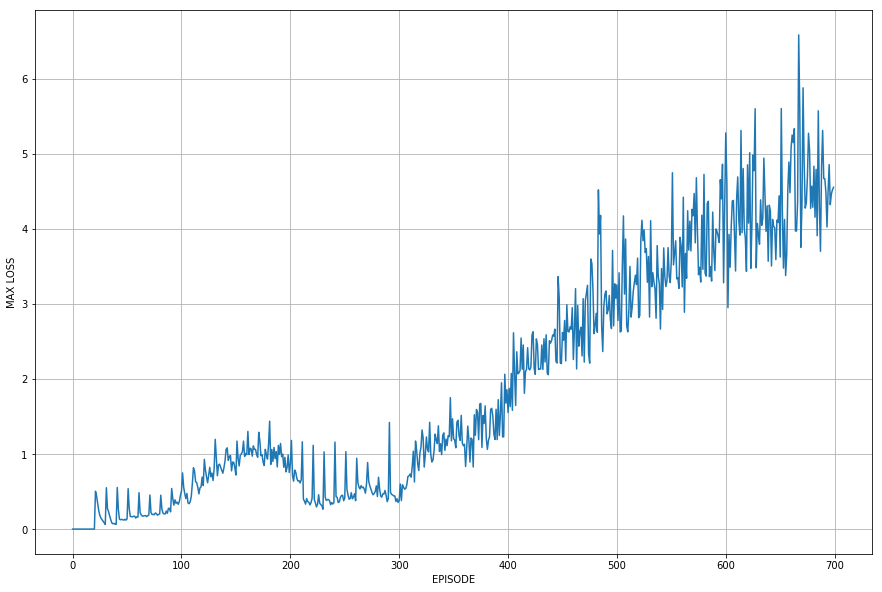

In [14]:
def plot_loss():
    plt.figure(figsize=(15,10))
    plt.xlabel('EPISODE')
    plt.ylabel('MAX LOSS')
    plt.plot(MAX_LOSS)
    plt.grid()
    plt.show()
plot_loss()